# Topic modeling with PyMC3

This article is an introduction to [topic models](https://en.wikipedia.org/wiki/Topic_model) and their implementation with [PyMC3](https://docs.pymc.io/). It is mainly targeted at readers with little or no prior PyMC3 experience. The examples focus on simplicity rather than efficiency and I'll provide links to more efficient implementations at the end of the article. I'll also show how mathematical descriptions of topic models relate to PyMC3 code. For this article it is helpful to have a basic understanding of probability theory. 

PyMC3 is an open source probabilistic programming library. It allows the specification of Bayesian statistical models with an intuitive syntax on an abstraction level similar to that of their mathematical descriptions and [plate notations](https://en.wikipedia.org/wiki/Plate_notation). PyMC3 does automatic [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) for unknown variables in probabilistic models via [Markow Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) sampling or via [automatic differentiation variational inference](https://arxiv.org/abs/1603.00788) (ADVI). 

MCMC is an approach to Bayesian inference that works for many complex models but it can be quite slow. A much faster alternative is often ADVI. If uncertainty estimates are not needed maximium-a-posteriori (MAP) estimation is another alternative that is very fast. Both ADVI and MAP estimation are optimization problems whereas MCMC is a sampling problem. Ideally, we have an analytical solution for the posterior but this is only feasible for some simpler models. 

In this article MCMC is used to obtain posterior estimates for unknown model variables. I won't introduce PyMC3 from scratch here and therefore recommend to read the initial sections of the PyMC3 [getting started guide](https://docs.pymc.io/notebooks/getting_started.html) first (up to and including the linear regression example). But even without reading it you should be able to follow this article and get an intuition how PyMC3 can be used to implement topic models. The following implementation examples are based on PyMC3 version 3.5.

## Topic models

Topic models are statistical models for discovering abstract topics in a collection of documents. For example, a document containing words like "dog", "cat" or "rat" likely has a different underlying topic than a document containing words like "CPU", "GPU" or "RAM". When learning a topic model only the words in documents are observed, the topics to be discovered are not observed. The random variables that model topics are therefore called hidden or latent variables and the corresponding model is called a latent variable model. When learning a latent variable model, the latent variables are inferred together with the other unknown model parameters.

The topic models presented in this article are [generative models](https://en.wikipedia.org/wiki/Generative_model). These models learn a joint probability distribution $p(x, z) = p(x \lvert z)p(z)$ over observed words $x$ in a training dataset and hidden topics $z$. By sampling from this distribution new documents can be generated from their underlying topic(s), hence the term *generative model*. This is in contrast to a *discriminative model* that only learns a probability distribution $p(z \lvert x)$ over topics given a word $x$ or a set of words, often used in a supervised learning context where topics (classes) are observed.

Throughout the following examples an over-simplified set of `documents` is used. The documents contain words that we can categorize into topics *programming languages*, *machine learning* and *databases*. During inference though only abstract topics `0`, `1`, `2`, ... are assigned to documents and words, semantic interpretation is up to us. For all presented models, the number of topics $K$ is pre-defined based on our intuition and is not inferred. For processing documents with PyMC3 they are categorically encoded based on the entries in a `vocabulary`.

In [1]:
from sklearn.preprocessing import LabelEncoder

documents = [['Python', 'Scala', 'Python', 'Python', 'Java'],
             ['Scala', 'Python', 'Python', 'Java', 'Scala'],
             ['Python', 'Python', 'Scala', 'Python'],
             ['Java', 'Java', 'Java', 'Scala', 'Scala'],
             ['Scala', 'Scala', 'Scala', 'Python', 'Java', 'Scala', 'deep learning'],
             ['Python', 'Scala', 'Python', 'Python', 'Python', 'machine learning'],
             ['Java', 'Python', 'Python', 'Java', 'Scala'],
             ['deep learning', 'statistics', 'machine learning', 'Python'],
             ['machine learning', 'machine learning', 'deep learning', 'deep learning', 'machine learning'],
             ['statistics', 'Python', 'statistics', 'statistics', 'deep learning', 'Postgres'],
             ['deep learning', 'machine learning', 'machine learning', 'deep learning', 'deep learning', 'Postgres'],
             ['MySQL', 'Cassandra', 'Postgres', 'Postgres', 'Postgres', 'machine learning'],
             ['Cassandra', 'Cassandra', 'Postgres', 'Scala', 'MySQL', 'MySQL']]

# Number of topics
K = 3

# Number of documents 
D = len(documents)

# (Ab)use label encoder for categorical encoding of words
encoder = LabelEncoder()
encoder.fit([word for document in documents for word in document])

# Vocabulary derived from documents
vocabulary = encoder.classes_

# Vocabulary size 
V = len(vocabulary)

# Encoded documents
X = [encoder.transform(d) for d in documents]

### Naive Bayes model

We start with a simple topic model where each document is assigned a single topic based on the words contained in that document i.e. documents are classified into different topics. We further assume that the occurence of one word in a document doesn't give any additional information about the occurence of other words in that document. The distribution of words in a document only depends on the topic of that document. This means that the words in a document are conditionally independent i.e. independent given the document's topic. Models that make this naive assumption are called *Naive Bayes* models. 

The mathematical description of the model is

$$
\begin{align*}
\boldsymbol{\theta} &\sim \mathrm{Dir(\boldsymbol\alpha)} \\
\boldsymbol{\phi}_{k=1,\ldots,K} &\sim \mathrm{Dir(\boldsymbol\beta)} \\
z_{d=1,\ldots,D} &\sim \mathrm{Cat}(\boldsymbol{\theta}) \\
w_{d=1,\ldots,D,n=1,\ldots,N_d} &\sim \mathrm{Cat}(\boldsymbol{\phi}_{z_{d}})
\end{align*}
$$

where 

- $\boldsymbol\theta$ is a random variable that models the global topic distribution. It is a $K$-dimensional random vector whose elements are the global topic probabilities. They must be non-negative and sum up to 1. A prior distribution that enforces these constraints is the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). It is parameterized with hyper-parameter $\boldsymbol\alpha$. We start with a uniform prior and therefore set $\boldsymbol\alpha = \boldsymbol{1}$.

- $\boldsymbol\phi_k$ is a random variable that models the word distribution of topic $k$. It is a $V$-dimensional vector whose elements are the probabilities of vocabulary words where $V$ is the size of the vocabulary. The prior is also a Dirichlet distribution but with hyper-parameter $\boldsymbol\beta$. Our assumption is that only a small set of words from the vocabulary have higher probability per topic. We therefore define a sparse Dirichlet prior by setting the elements of $\boldsymbol\beta$ to values $<1$.

- $z_d$ is the topic of document $d$. It follows a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) that is parameterized by $\boldsymbol\theta$.

- $w_{dn}$ is the $n$-th word of document $d$. It also follows a categorical distribution that is parameterized by $\boldsymbol\phi_{z_{d}}$ i.e. the word distribution of topic $z_d$.

From a generative model perspective, a document's words can be generated by first sampling a topic from the global topic distribution and then sampling the words from that topic's word distribution. For drawing the words of a document we could also use a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution) but for easier comparison with the model in the next section we use a categorical distribution. The model can be summarized with the following plate notation:

![nbm](images/topic-models/nbm.png?v2)

Model specification with PyMC3 closely follows its mathematical description:

In [2]:
import numpy as np
import pymc3 as pm

# Hyper-parameter for uniform Dirichlet prior
alpha = np.ones(K)

# Hyper-parameter for sparse Dirichlet prior
beta = np.ones(V) * 0.3

with pm.Model() as model:
    # Global topic distribution
    theta = pm.Dirichlet('theta', a=alpha)
    
    # Word distributions for K topics
    phi = pm.Dirichlet('phi', a=beta, shape=(K, V))
    
    # Topic of documents
    z = pm.Categorical('z', p=theta, shape=(D,))
    
    for i in range(D):
        # Words of document
        w = pm.Categorical(f'w_{i}', p=phi[z[i]], observed=X[i])

- Variables $\boldsymbol\phi_k$ from the mathematical description are implemented as PyMC3 random variable `phi` with shape `(K, V)`. The variable name is the first argument to the distribution constructor.

- Variables $z_d$ are implemented as PyMC3 random variable `z` with shape `(D,)` where $D$ is the number of documents (13 in our example). 

- Variables $w_{dn}$ are implemented as PyMC3 random variables `w_0`, `w_1`, ..., `w_12`, one for each document. These variables are observed and linked to training data via the `observed` parameter. These variables are not changed during model fitting. Their shape is derived from the number of words in a document.

Next step is to infer the global topic distribution, the word distribution for each topic and the topic for each document. The corresponding estimates for `theta`, `phi` and `z` are computed from posterior samples obtained via MCMC.

In [3]:
with model:    
    trace = pm.sample(2000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [phi, theta]
>CategoricalGibbsMetropolis: [z]
100%|██████████| 2500/2500 [00:21<00:00, 118.32it/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


The `trace` object returned by `pm.sample` contains `2000` posterior samples for variables `theta`, `phi` and `z`. For visualizing `theta` posterior estimates we use the built-in `pm.plot_posterior` function. It plots the mean and the 95% highest posterior density (HPD) interval for each element of random vector `theta` i.e. `theta_0`, `theta_1` and `theta_2`. 

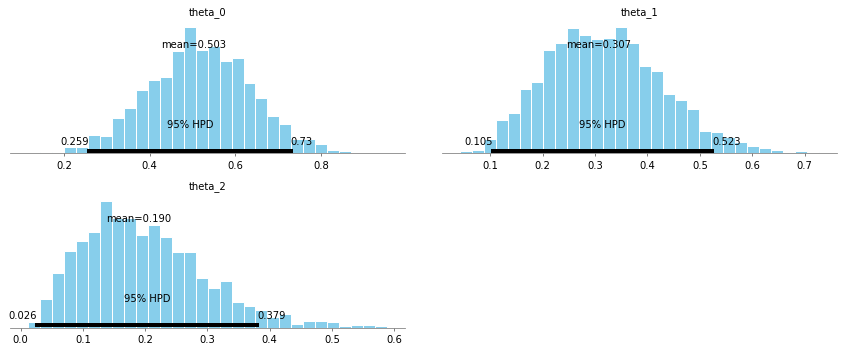

In [4]:
pm.plot_posterior(trace, varnames=['theta']);

The posterior means closely match the relative frequency or distribution of topics in our dataset of 13 documents: 7 documents are related to programming languages, 4 documents are related to machine learning and 2 documents are related to databases. 

For visualizing the prominent words of each topic we plot [kernel density estimates](https://en.wikipedia.org/wiki/Kernel_density_estimation) for each element of `phi`. We can see that for topic `0` the words with the highest probabilities are "Python", "Scala" and "Java", for topic `1` these are "deep learning", "machine learning" and "statistics" and for topic `2` "Postgres", "MySQL" and "Cassandra".

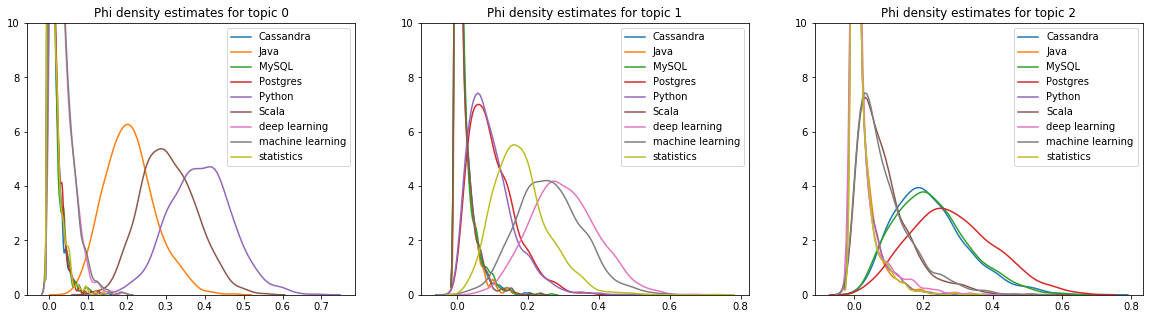

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phi_estimates(trace):
    plt.figure(figsize=(20,5))
    for i in range(K):
        plt.subplot(1, 3, i+1)
        for j in range(V):
            sns.distplot(trace['phi'][:, i, j], kde=True, hist=False, label=vocabulary[j])
            plt.ylim([0, 10])
        plt.title(f'Phi density estimates for topic {i}')
        plt.legend(vocabulary)
        
plot_phi_estimates(trace)

For obtaining the topic of each document we compute the posterior mode of `z` but omit computing uncertainty estimates here.

In [6]:
for i in range(D):
    topics, counts = np.unique(trace['z'][:, i], return_counts=True)
    print(f'Topic of document {i: >2} = {topics[np.argmax(counts)]}')

Topic of document  0 = 0
Topic of document  1 = 0
Topic of document  2 = 0
Topic of document  3 = 0
Topic of document  4 = 0
Topic of document  5 = 0
Topic of document  6 = 0
Topic of document  7 = 1
Topic of document  8 = 1
Topic of document  9 = 1
Topic of document 10 = 1
Topic of document 11 = 2
Topic of document 12 = 2


### Latent Dirichlet allocation

Making the assumption that a document has only a single underlying topic is often too restrictive. A more realistic assumption is that a document is made up of a mixture of topics. Instead of having a global topic distribution we want to have a topic distribution per document. By additionally allowing the assignment of topics to individual words we end up with a topic model called [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA). It is a popular topic model that can be summarized with the following plate notation:

![lda](images/topic-models/lda.png?v2)

The difference to the Naive Bayes model is that the $D$ and $N_d$ plates are extended by one node to the left. The LDA model can be mathematically described as 

$$
\begin{align*}
\boldsymbol{\theta}_{d=1,\ldots,D} &\sim \mathrm{Dir(\boldsymbol\alpha)} \\
\boldsymbol{\phi}_{k=1,\ldots,K} &\sim \mathrm{Dir(\boldsymbol\beta)} \\
z_{d=1,\ldots,D,n=1,\ldots,N_d} &\sim \mathrm{Cat}(\boldsymbol{\theta}_d) \\
w_{d=1,\ldots,D,n=1,\ldots,N_d} &\sim \mathrm{Cat}(\boldsymbol{\phi}_{z_{dn}})
\end{align*}
$$

where 

- $\boldsymbol\theta_d$ is the topic distribution of document $d$. We assume that only a small number of topics have higher probability per document and therefore use a sparse Dirichlet prior for $\boldsymbol\theta_d$.  

- $\boldsymbol\phi_k$ is the word distribution of topic $k$, as in the previous model.

- $z_{dn}$ is the topic of word $w_{dn}$. It follows a categorical distribution that is parameterized by $\boldsymbol\theta_d$.

- $w_{dn}$ is the $n$-th word of document $d$. It also follows a categorical distribution that is parameterized by $\boldsymbol\phi_{z_{dn}}$ i.e. the word distribution of topic $z_{dn}$.

Model specification with PyMC3 again closely follows the mathematical description:

In [7]:
alpha = np.ones(K) * 0.3
beta = np.ones(V) * 0.3

with pm.Model() as model:
    phi = pm.Dirichlet("phi", a=beta, shape=(K, V))

    for i in range(D):
        theta = pm.Dirichlet(f"theta_{i}", a=alpha)
        
        z = pm.Categorical(f"z_{i}", p=theta, shape=X[i].shape)
        w = pm.Categorical(f"w_{i}", p=phi[z], observed=X[i])

- Variables $\boldsymbol\theta_d$ from the mathematical description are now implemented inside the `for` loop as PyMC3 random variables `theta_0`, ..., `theta_12`, one for each document. 

- Variables $z_{dn}$ are implemented inside the `for` loop as PyMC3 variables `z_0`, ..., `z_12`. Their shape is derived from the number of words in the document. 

- The implementation of variables $\boldsymbol\phi_k$ and $w_{dn}$ is identical to the previous model.

Again, we draw 2000 posterior samples via MCMC so that we can compute estimates.

In [8]:
with model:    
    trace = pm.sample(2000, chains=1, nuts_kwargs={'target_accept': 0.9})

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [theta_12, theta_11, theta_10, theta_9, theta_8, theta_7, theta_6, theta_5, theta_4, theta_3, theta_2, theta_1, theta_0, phi]
>CategoricalGibbsMetropolis: [z_12, z_11, z_10, z_9, z_8, z_7, z_6, z_5, z_4, z_3, z_2, z_1, z_0]
100%|██████████| 2500/2500 [04:24<00:00, 10.07it/s]
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


The density estimates for `phi` are similar to the previous example which is expected. Only the assignment of topic numbers may change between MCMC runs.

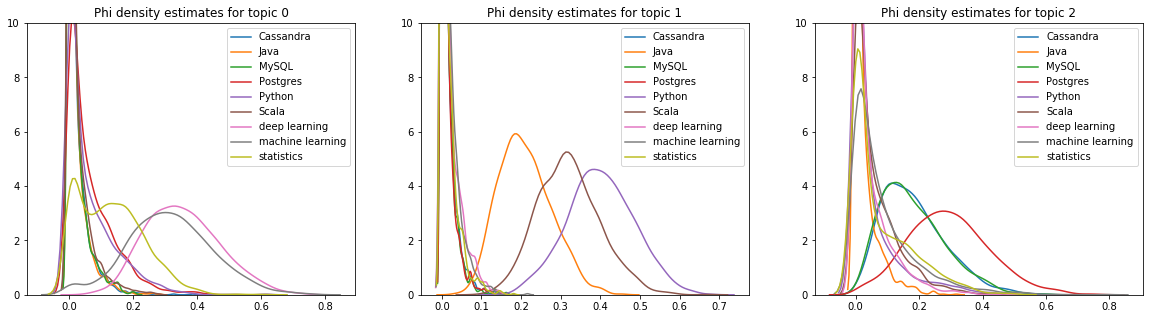

In [9]:
plot_phi_estimates(trace)

We can additionally analyze the topic distributions per document. In the following output we see that in documents 0-6 topic 1 has the highest probability, in documents 7-10 it is topic 0 and in documents 11-12 it is topic 2. In addition to the $\boldsymbol\theta_d$ mean values the 95% HPD interval is computed for the topic with the highest probability. 

In [10]:
import pandas as pd

data = []

for i in range(D):
    row = np.mean(trace[f'theta_{i}'], axis=0).tolist()
    row.extend(pm.stats.hpd(trace[f'theta_{i}'])[np.argmax(row)])
    data.append(row)
    
pd.options.display.float_format = '{:,.3f}'.format    
df = pd.DataFrame(data, columns=['$\\boldsymbol\\theta_{d,0}$', 
                                 '$\\boldsymbol\\theta_{d,1}$', 
                                 '$\\boldsymbol\\theta_{d,2}$', 'HPD 2.5', 'HPD 97.5'])
df.index.name = 'Document'
df

,"$\boldsymbol\theta_{d,0}$","$\boldsymbol\theta_{d,1}$","$\boldsymbol\theta_{d,2}$",HPD 2.5,HPD 97.5
Document,,,,,
0,0.056,0.871,0.072,0.534,1.000
1,0.063,0.877,0.061,0.603,1.000
2,0.077,0.838,0.086,0.447,1.000
3,0.057,0.879,0.064,0.599,1.000
4,0.133,0.800,0.067,0.460,1.000
5,0.171,0.734,0.094,0.307,1.000
6,0.056,0.885,0.060,0.630,1.000
7,0.630,0.193,0.177,0.091,1.000
8,0.853,0.055,0.092,0.426,1.000


The topic distribution for document with index 9 is less skewed compared to other documents which makes sense since it contains words from all three topics. To obtain the topic for each word in that document we compute the posterior mode of `z_9`, again skipping the computation of uncertainty estimates.

In [12]:
doc_idx = 9

for i, w in enumerate(documents[doc_idx]):
    topics, counts = np.unique(trace[f'z_{doc_idx}'][:, i], return_counts=True)
    print(f'Topic of word "{w}" = {topics[np.argmax(counts)]}')

Topic of word "statistics" = 0
Topic of word "Python" = 1
Topic of word "statistics" = 0
Topic of word "statistics" = 0
Topic of word "deep learning" = 0
Topic of word "Postgres" = 2


The results make perfectly sense, topics have been correctly assigned to words. For more options to analyze MCMC traces you may want to take a look at the PyMC3 modules [stats](https://docs.pymc.io/api/stats.html) and [plots](https://docs.pymc.io/api/plots.html).

It is quite easy to get started with topic modeling in PyMC3 but for significantly larger datasets more efficient implementations are necessary. A PyMC3 example based on automatic differentiation variational inference (ADVI) is [here](https://docs.pymc.io/notebooks/lda-advi-aevb.html). An efficient implementation in [scikit-learn](https://scikit-learn.org/stable/index.html) is [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) which is also based on a variational Bayes algorithm.

## Appendix

### Code for plate notations

[DAFT](http://daft-pgm.org/) is used for generating plate notation figures.

In [13]:
import daft

#### Naive Bayes model

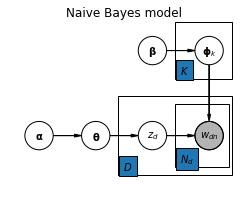

In [14]:
pgm = daft.PGM([4, 3], origin=(-0.5, -1))
pgm.add_node(daft.Node("alpha", r"$\mathbf{\alpha}$", 0, 0))
pgm.add_node(daft.Node("beta", r"$\mathbf{\beta}$", 2, 1.5))
pgm.add_node(daft.Node("theta", r"$\mathbf{\theta}$", 1, 0))
pgm.add_node(daft.Node("phi", r"$\mathbf{\phi}_k$", 3, 1.5))
pgm.add_node(daft.Node("z", r"$z_{d}$", 2, 0))
pgm.add_node(daft.Node("w", r"$w_{dn}$", 3, 0, observed=True))
pgm.add_edge("alpha", "theta")
pgm.add_edge("beta", "phi")
pgm.add_edge("theta", "z")
pgm.add_edge("phi", "w")
pgm.add_edge("z", "w")
pgm.add_plate(daft.Plate([2.4, 1.0, 1.0, 1.0], label=r"$K$"))
pgm.add_plate(daft.Plate([1.4, -0.7, 2.0, 1.4], label=r"$D$"))
pgm.add_plate(daft.Plate([2.4, -0.55, 0.95, 1.1], label=r"$N_d$"))
ax = pgm.render()
ax.set_title('Naive Bayes model');

#### Latent Dirichlet allocation

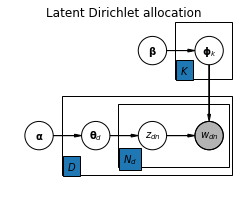

In [15]:
pgm = daft.PGM([4, 3], origin=(-0.5, -1))
pgm.add_node(daft.Node("alpha", r"$\mathbf{\alpha}$", 0, 0))
pgm.add_node(daft.Node("beta", r"$\mathbf{\beta}$", 2, 1.5))
pgm.add_node(daft.Node("theta", r"$\mathbf{\theta}_d$", 1, 0))
pgm.add_node(daft.Node("phi", r"$\mathbf{\phi}_k$", 3, 1.5))
pgm.add_node(daft.Node("z", r"$z_{dn}$", 2, 0))
pgm.add_node(daft.Node("w", r"$w_{dn}$", 3, 0, observed=True))
pgm.add_edge("alpha", "theta")
pgm.add_edge("beta", "phi")
pgm.add_edge("theta", "z")
pgm.add_edge("phi", "w")
pgm.add_edge("z", "w")
pgm.add_plate(daft.Plate([2.4, 1.0, 1.0, 1.0], label=r"$K$"))
pgm.add_plate(daft.Plate([0.4, -0.7, 3.0, 1.4], label=r"$D$"))
pgm.add_plate(daft.Plate([1.4, -0.55, 1.95, 1.1], label=r"$N_d$"))
ax = pgm.render()
ax.set_title('Latent Dirichlet allocation');